In [18]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
class MyDataset(Dataset):
    # 构造函数
    def __init__(self, data_tensor, target_tensor):
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor
    # 返回数据集大小
    def __len__(self):
        return self.data_tensor.size(0)
    # 返回索引的数据与标签
    def __getitem__(self, index):
        return self.data_tensor[index], self.target_tensor[index]

In [3]:
def map_array(arr):
    mapped_array = []
    for num in arr:
        if num == 0:
            mapped_array.append([1, 0])
        elif num == 1:
            mapped_array.append([0, 1])
    return mapped_array

In [19]:
from scipy.io import loadmat
file6 = "D:\\320 Deep-learning\data\\1118_S6_time1000.mat"
data6 = loadmat(file6)
file12 = "D:\\320 Deep-learning\data\\1111_S12_time1000.mat"
data12 = loadmat(file12)
file24 = "D:\\320 Deep-learning\data\\1111_S24_time1000.mat"
data24 = loadmat(file24)
""" experiment
X_train = data['Input']
X_train = torch.from_numpy(X_train).float()
y_train = data['Stability']
y_train = y_train.astype(np.float32) / 255
y_train = torch.tensor(y_train)
len_train = len(y_train)
X_test = data['PreInput']
X_test = torch.from_numpy(X_test).float()
y_test = data['PreSta']
y_test = y_test.astype(np.float32) / 255
y_test = torch.tensor(y_test)
len_test = len(y_test) """

#simulation
X6 = data6['Input_Abundance']
X6 = torch.from_numpy(X6).float()
y6 = data6['Stability']
y6 = torch.from_numpy(y6).float()

X12 = data12['Input_RelativeAbundance']
X12 = torch.from_numpy(X12).float()
y12 = data12['Stability']
y12 = torch.from_numpy(y12).float()

X24 = data24['Input_RelativeAbundance']
X24 = torch.from_numpy(X24).float()
y24= data24['Stability']
y24 = torch.from_numpy(y24).float()

t = 500
X_train = X6[0:t,:]
#y_train = y6[0:t]
X_test = X6[t:1000,:]
#y_test = y6[t:1000]
y_train = sum(X6[0:t,:].T)
y_test = sum(X6[t:1000,:].T)
#print(y_train)
len_train = len(y_train)
len_test = len(y_test)

# 将数据封装成Dataset
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

AttributeError: 'torch.dtype' object has no attribute 'kind'

In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 10

""" 需不需要随机采样？ 随机采样和shuffle是不是一样的 """
""" # define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, num_workers = num_workers) """

# prepare data loaders
train_dataloader = DataLoader(dataset = train_dataset, # 传入的数据集, 必须参数
                               batch_size = batch_size,       # 输出的batch大小
                               shuffle = True,       # 数据是否打乱
                               num_workers = num_workers)      # 进程数, 0表示只有主进程
test_dataloader = DataLoader(dataset = test_dataset, # 传入的数据集, 必须参数
                               batch_size = batch_size,       # 输出的batch大小
                               shuffle = True,       # 数据是否打乱
                               num_workers = num_workers)      # 进程数, 0表示只有主进程

#for data,target in train_dataloader:
#    print(target.size(1))

In [10]:
import torch.nn as nn
import torch.nn.functional as F

# define NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(54, 54)
        self.fc2 = nn.Linear(54, 2)
    def forward(self,x):
        #x = self.fc1(x) 
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

# initialize the NN
model = Net()
#print(model)

In [11]:
class BinaryFocalLoss(nn.Module):
    """
    Focal_Loss= -1*alpha*(1-pt)*log(pt)
    :param alpha: (tensor) 3D or 4D the scalar factor for this criterion
    :param gamma: (float,double) gamma > 0 reduces the relative loss for well-classified examples (p>0.5) putting more
                    focus on hard misclassified example
    :param reduction: `none`|`mean`|`sum`
    """

    def __init__(self, alpha=1, gamma=2, reduction='mean', **kwargs):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = 1e-6  # set '1e-4' when train with FP16
        self.reduction = reduction

        assert self.reduction in ['none', 'mean', 'sum']

    def forward(self, output, target):
        prob = torch.sigmoid(output)
        prob = torch.clamp(prob, self.smooth, 1.0 - self.smooth)

        target = target.unsqueeze(dim=1)
        pos_mask = (target == 1).float()
        neg_mask = (target == 0).float()

        pos_weight = (pos_mask * torch.pow(1 - prob, self.gamma)).detach()
        pos_loss = -pos_weight * torch.log(prob)  # / (torch.sum(pos_weight) + 1e-4)

        neg_weight = (neg_mask * torch.pow(prob, self.gamma)).detach()
        neg_loss = -self.alpha * neg_weight * F.logsigmoid(-output)  # / (torch.sum(neg_weight) + 1e-4)

        loss = pos_loss + neg_loss
        loss = loss.mean()
        return loss

In [14]:
# specify loss function
criterion = nn.CrossEntropyLoss()
#criterion = BinaryFocalLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)

tensor([[0.5213, 0.4945],
        [0.5252, 0.5194],
        [0.5240, 0.5191],
        [0.5222, 0.5177],
        [0.5330, 0.5178],
        [0.5110, 0.5209],
        [0.5229, 0.5378],
        [0.5187, 0.5246],
        [0.5236, 0.5092],
        [0.5322, 0.5222]], grad_fn=<SigmoidBackward0>)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.6906, grad_fn=<NllLossBackward0>)
tensor([[0.5409, 0.4884],
        [0.5245, 0.4940],
        [0.5480, 0.4902],
        [0.5487, 0.4907],
        [0.5520, 0.4815],
        [0.5238, 0.4709],
        [0.5386, 0.4790],
        [0.5323, 0.4956],
        [0.5332, 0.4907],
        [0.5505, 0.4778]], grad_fn=<SigmoidBackward0>)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.6668, grad_fn=<NllLossBackward0>)
tensor([[0.5606, 0.4683],
        [0.5503, 0.4860],
        [0.5553, 0.4673],
        [0.5710, 0.4723],
        [0.5575, 0.4622],
        [0.5465, 0.4874],
        [0.5617, 0.4891],
        [0.5592, 0.4497],
        [0.5468, 0.4662],
        [0.5484, 0.4608]

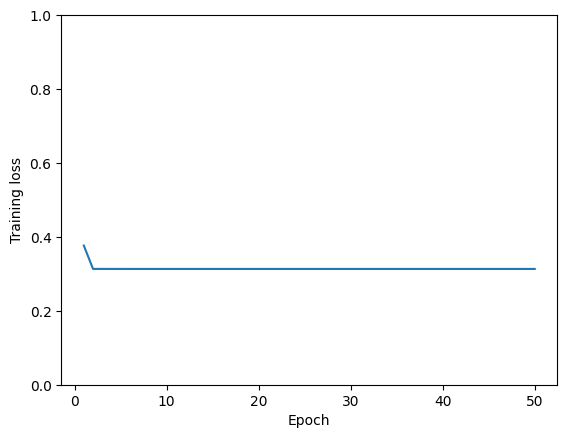

In [15]:
# number of epochs to train the model
n_epochs = 50
train_loss_min = np.Inf  # set initial "min" to infinity
train_loss_curve = list()

for epoch in range(n_epochs):
    train_loss = 0
    # train the model #
    loss = 0
    for data, target in train_dataloader: 
        optimizer.zero_grad()
        output = model(data)
        #make target a tensor:torch.Size([10]),dtype = long
        target = target.view(batch_size)
        target = target.long()
        #target = target.T
        loss = criterion(output,target)
        print(output)
        print(target)
        print(loss)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    # calculate average loss over an epoch
    train_loss = train_loss / len_train
    train_loss_curve.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))
    
    # save model
    if train_loss <= train_loss_min:
        print('Train loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        train_loss_min,
        train_loss))
        torch.save(model.state_dict(), 'model.pt')
        train_loss_min = train_loss
plt.plot(np.linspace(1,n_epochs,n_epochs),train_loss_curve)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.ylim(0,1)
plt.show()